# Lattice CNN

In [ ]:
import networkx as nx
import numpy as np

class MeetSemiLattice():
	def __init__(self, L):
		self.L = L
		self.DLT, self.DLT_inv = self._compute_DLT()

		#print(self.DLT)
		#print(self.DLT_inv)

	def _compute_DLT(self):
		F = np.zeros((self.L.number_of_nodes(), self.L.number_of_nodes()))
		lengths = dict(nx.all_pairs_shortest_path_length(self.L))

		for n1 in range(self.L.number_of_nodes()):
			for n2 in range(self.L.number_of_nodes()):
				if n2 in lengths[n1]:
					F[n1][n2] = 1

		return np.linalg.inv(F), F


G = nx.OrderedDiGraph()
G.add_nodes_from(range(7))
G.add_edges_from([(0,1), (0,3), (1,4), (2,4), (3,6), (4,6), (5,6)])

L = MeetSemiLattice(G)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimizer
import torch.nn.functional as F
from torch.autograd import Variable
from opt_einsum import contract_expression

from tqdm import tqdm
import matplotlib.pyplot as plt

class MeetConv(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, bias=True, device=None):
    super().__init__()
    self.has_bias = bias
    self.expr_shape = None
    self.size = L.L.number_of_nodes()
    self.DLT = Variable(torch.Tensor(L.DLT))
    self.DLT_inv = Variable(torch.Tensor(L.DLT_inv))

    self.filter = nn.Parameter(torch.empty(in_channels, out_channels, self.size))
    nn.init.xavier_normal(self.filter)
    
    if self.has_bias:
      self.bias = nn.Parameter(torch.empty(out_channels, self.size))
      nn.init.xavier_normal(self.bias)
    
    #self.filter = torch.Tensor([0, 0, 0, 0, 1, 1, 1, 0])

    if device is not None:
      self.DLT = self.DLT.to(device)
      self.DLT_inv = self.DLT_inv.to(device)

  def forward(self, x):
    #x = torch.einsum('nm,bcm->bcn', self.DLT, x)
    #x = torch.einsum('ion,bin->bon', self.filter, x)
    #x = torch.einsum('nm,bcm->bcn', self.DLT_inv, x)

    if not self.expr_shape == x.shape:
      self.expr_shape = x.shape
      self.expr = contract_expression('nm,com,ml,bcl->bon', self.DLT_inv, self.filter.shape, self.DLT, x.shape, constants=[0, 2])

    #x = contract('nm,com,ml,bcl->bon', self.DLT_inv, self.filter, self.DLT, x, backend='torch')
    x = self.expr(self.filter, x, backend='torch')
    return x + (self.bias if self.has_bias else 0)

class JoinConv(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, bias=True, device=None):
    super().__init__()
    self.has_bias = bias
    self.expr_shape = None
    self.size = L.L.number_of_nodes()
    self.DLT = Variable(torch.Tensor(L.DLT.T))
    self.DLT_inv = Variable(torch.Tensor(L.DLT_inv.T))
    self.bias = nn.Parameter(torch.empty(out_channels, self.size))
    self.filter = nn.Parameter(torch.empty(in_channels, out_channels, self.size))
    
    nn.init.xavier_normal(self.filter)
    #nn.init.kaiming_normal_(self.filter, a=0.01)

    if self.has_bias:
      self.bias = nn.Parameter(torch.empty(out_channels, self.size))
      nn.init.xavier_normal(self.bias)

    if device is not None:
      self.DLT = self.DLT.to(device)
      self.DLT_inv = self.DLT_inv.to(device)

  def forward(self, x):
    #x = torch.einsum('nm,bcm->bcn', self.DLT, x)
    #x = torch.einsum('ion,bin->bon', self.filter, x)
    #x = torch.einsum('nm,bcm->bcn', self.DLT_inv, x)

    if not self.expr_shape == x.shape:
      self.expr_shape = x.shape
      self.expr = contract_expression('nm,com,ml,bcl->bon', self.DLT_inv, self.filter.shape, self.DLT, x.shape, constants=[0, 2])

    #x = contract('nm,com,ml,bcl->bon', self.DLT_inv, self.filter, self.DLT, x, backend='torch')
    x = self.expr(self.filter, x, backend='torch')
    return x + (self.bias if self.has_bias else 0)

class LatticeNet(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, n_layers=3, n_filters=16, device=None):
    super().__init__()
    self.last_m = MeetConv(L, in_channels=n_filters, out_channels=in_channels, device=device)
    self.first_m = MeetConv(L, in_channels=in_channels, out_channels=n_filters, device=device)
    self.meet_layers = nn.ModuleList([self.first_m] + 
                                     [MeetConv(L, in_channels=n_filters, out_channels=n_filters, device=device) for _ in range(n_layers)])
    
    self.last_j = JoinConv(L, in_channels=n_filters, out_channels=in_channels, bias=False, device=device)
    self.first_j = JoinConv(L, in_channels=in_channels, out_channels=n_filters, bias=False, device=device)
    self.join_layers = nn.ModuleList([self.first_j] + 
                                     [JoinConv(L, in_channels=n_filters, out_channels=n_filters, bias=False, device=device) for _ in range(n_layers)])
    
  def forward(self, x):
    for m, j in zip(self.meet_layers, self.join_layers): #for m in self.meet_layers[:-1]: #
      x = nn.LeakyReLU()(m(x) + j(x))
      #x = nn.LeakyReLU()(torch.cat([m(x), j(x)], dim=1))

    return self.last_m(x) + self.last_j(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import time

X = x.detach().cpu().numpy()
dlt = l_net.conv.DLT
inv = l_net.conv.DLT_inv
filt = l_net.conv.filter
test_F = torch.unsqueeze(torch.unsqueeze(torch.Tensor([0. for _ in range(120)] + [1. for _ in range(7)] + [0.]).to(device), dim=0), dim=1)

rand_shift = np.zeros(X.shape[0], dtype=np.int) #np.random.randint(0, high=X.shape[1], size=X.shape[0])#
X = torch.unsqueeze(torch.Tensor(shift_batch(S, X, rand_shift)).to(device), dim=1)
y_shift = torch.Tensor(shift_batch(S, y_true.detach().cpu(), rand_shift)).to(device)

FLT = test_F #filt # 


start1 = time.time()
z = torch.einsum('nm,bcm->bcn', dlt, X)
z = torch.einsum('ion,bin->bon', FLT, z)
z = torch.einsum('nm,bcm->bcn', inv, z)
end1 = time.time()

start2 = time.time()
#alpha = torch.einsum('nm,com,ml,bcl->bon', inv, FLT, dlt, X)
alpha = contract('nm,com,ml,bcl->bon', inv, FLT, dlt, X)
end2 = time.time()

print(torch.sum(alpha - z))
print(alpha)
print(z)
print(y_shift)
print(torch.sum(torch.abs(torch.squeeze(z)-y_shift))/y_shift.numel())
print(f'old:{end1 - start1} - new:{end2 - start2} - improvement:{100*(1 - (end2-start2)/(end1-start1))}%')

AttributeError: ignored

In [ ]:
batch_size = 16
net = LatticeNet(MeetSemiLattice(G), n_layers=0, n_filters=256) #n_layers=2, n_filters=3)
print(sum(p.numel() for p in net.parameters() if p.requires_grad))
optim = optimizer.Adam(net.parameters())#, lr=0.001, momentum=0.9)

for epoch in range(10000):
  x = torch.Tensor(np.random.rand(batch_size, 1, L.L.number_of_nodes()))
  y_true = torch.Tensor(np.ones((batch_size, L.L.number_of_nodes())))
  optim.zero_grad()
  y_pred = net(x)
  
  loss = torch.mean(torch.sum(torch.abs(y_true - torch.squeeze(y_pred)), dim=1))
  loss.backward()
  optim.step()
  
  if not epoch % 50:
    print(f'epoch: {epoch} - loss: {loss.item()}')

#print(y_pred)
#print(net.conv2.filter)
#print(net.conv3.filter)

# Subset Sum Task

In [ ]:
class LatticeSumNet(nn.Module):
  def __init__(self, L, out_channels=1, device=None):
    super().__init__()
    self.conv1 = MeetConv(L, in_channels=1, out_channels=out_channels, bias=True, device=device)
    self.join1 = JoinConv(L, in_channels=1, out_channels=out_channels, bias=False, device=device)
  
  def forward(self, x):
    return self.conv1(x) + self.join1(x) #torch.squeeze(self.conv(x), dim=1)#torch.sum(self.conv(x), dim=2)

class TestSumNet(nn.Module):
  def __init__(self, L):
    super().__init__()
    self.linear = nn.Linear(L.L.number_of_nodes(), L.L.number_of_nodes())
  
  def forward(self, x):
    return self.linear(x)

In [ ]:
from itertools import chain, combinations


def powerset(iterable):
    s = list(iterable)
    return list(reversed(list(map(lambda t: set(t), chain.from_iterable(combinations(s, r) for r in range(len(s)+1))))))


def subset_lattice(n):
  p = powerset(range(n))
  edges = []
  for i in range(len(p)):
    for j in range(i+1, len(p)):
      if p[j].issubset(p[i]) and len(p[i]) == len(p[j]) + 1:
        edges.append((i, j))

  return list(map(lambda s:list(s), p)), edges


def compute_shift_matrix(G):
  shift_mat = np.zeros((G.number_of_nodes(), G.number_of_nodes()), dtype=np.int)
  for (u, v), lca in nx.all_pairs_lowest_common_ancestor(nx.reverse(G)):
    shift_mat[u, v] = u if u == v else lca
    shift_mat[v, u] = shift_mat[u, v]
  
  return shift_mat


def shift_batch(S, batch, shifts):
  return np.stack([b[S[s]] for b, s in zip(batch, shifts)])

N=3
perm, edges = subset_lattice(N)
print(perm)
powerset_G = nx.OrderedDiGraph()
powerset_G.add_nodes_from(range(2**N))
powerset_G.add_edges_from(edges)

S = compute_shift_matrix(powerset_G)
print(S)
[sum([1 if 2**N - N - 1 <= r < 2**N - 1 else 0 for r in row]) for row in S]
#shift_batch(S, np.random.rand(2, 2**5), [0, 7])

[[0, 1, 2], [1, 2], [0, 2], [0, 1], [2], [1], [0], []]


NameError: ignored



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


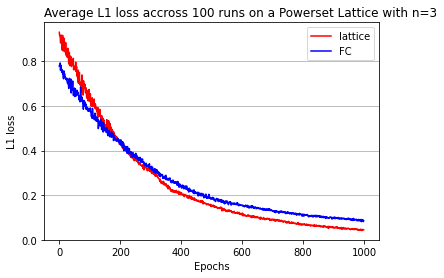



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:02<00:26,  2.91s/it]

 20%|██        | 2/10 [00:05<00:23,  2.91s/it]

 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


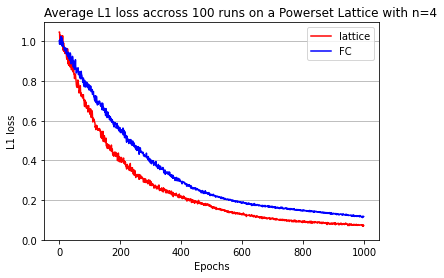



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:03<00:27,  3.09s/it]

 20%|██        | 2/10 [00:06<00:24,  3.08s/it]

 30%|███       | 3/10 [00:09<00:21,  3.09s/it]

 40%|████      | 4/10 [00:12<00:18,  3.10s/it]

 50%|█████     | 5/10 [00:15<00:15,  3.08s/it]

 60%|██████    | 6/10 [00:18<00:12,  3.08s/it]

 70%|███████   | 7/10 [00:21<00:09,  3.08s/it]

 80%|████████  | 8/10 [00:24<00:06,  3.08s/it]

 90%|█████████ | 9/10 [00:27<00:03,  3.08s/it]

100%|██████████| 10/10 [00:30<00:00,  3.08s/it]


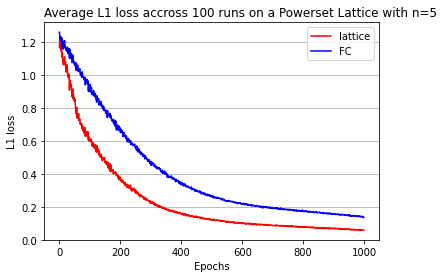



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:03<00:29,  3.33s/it]

 20%|██        | 2/10 [00:06<00:26,  3.32s/it]

 30%|███       | 3/10 [00:09<00:23,  3.31s/it]

 40%|████      | 4/10 [00:13<00:19,  3.31s/it]

 50%|█████     | 5/10 [00:16<00:16,  3.31s/it]

 60%|██████    | 6/10 [00:19<00:13,  3.30s/it]

 70%|███████   | 7/10 [00:23<00:09,  3.30s/it]

 80%|████████  | 8/10 [00:26<00:06,  3.30s/it]

 90%|█████████ | 9/10 [00:29<00:03,  3.30s/it]

100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


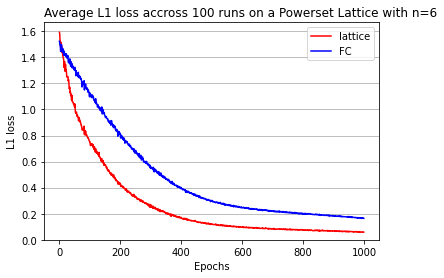



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:04<00:36,  4.08s/it]

 20%|██        | 2/10 [00:08<00:32,  4.07s/it]

 30%|███       | 3/10 [00:12<00:28,  4.08s/it]

 40%|████      | 4/10 [00:16<00:24,  4.08s/it]

 50%|█████     | 5/10 [00:20<00:20,  4.07s/it]

 60%|██████    | 6/10 [00:24<00:16,  4.06s/it]

 70%|███████   | 7/10 [00:28<00:12,  4.06s/it]

 80%|████████  | 8/10 [00:32<00:08,  4.05s/it]

 90%|█████████ | 9/10 [00:36<00:04,  4.06s/it]

100%|██████████| 10/10 [00:40<00:00,  4.06s/it]


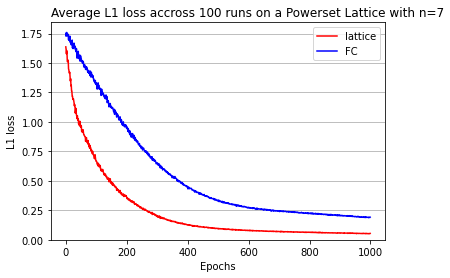



  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


 10%|█         | 1/10 [00:05<00:49,  5.51s/it]

 20%|██        | 2/10 [00:11<00:44,  5.51s/it]

 30%|███       | 3/10 [00:16<00:38,  5.52s/it]

 40%|████      | 4/10 [00:22<00:33,  5.51s/it]

 50%|█████     | 5/10 [00:27<00:27,  5.50s/it]

 60%|██████    | 6/10 [00:33<00:22,  5.51s/it]

 70%|███████   | 7/10 [00:38<00:16,  5.51s/it]

 80%|████████  | 8/10 [00:44<00:11,  5.51s/it]

 90%|█████████ | 9/10 [00:49<00:05,  5.49s/it]

100%|██████████| 10/10 [00:55<00:00,  5.50s/it]


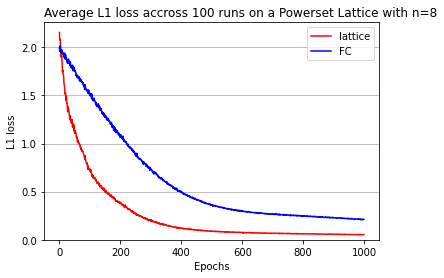

In [ ]:
epochs = 1000
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_nodes in range(3, 9):

  G = nx.OrderedDiGraph()
  permutations, edges = subset_lattice(n_nodes)
  G.add_nodes_from(range(np.power(2, n_nodes)))
  G.add_edges_from(edges)
  L = MeetSemiLattice(G)
  S = compute_shift_matrix(G)
  l_hist, t_hist = [], []

  for _ in tqdm(range(10)):

    lh, th  = [], []

    l_net = LatticeSumNet(L, out_channels=1, device=device)
    l_optim = optimizer.Adam(l_net.parameters())
    l_net.to(device)

    t_net = TestSumNet(L)
    t_optim = optimizer.Adam(t_net.parameters())
    t_net.to(device)

    for epoch in range(epochs):
      P = np.zeros((batch_size, np.power(2, n_nodes)))
      x = np.random.rand(n_nodes, batch_size)
      #x /= np.sum(x, axis=0)
      for i, p in enumerate(permutations): P[:, i] += np.sum(x[p], axis=0)
      x = np.flipud(np.vstack([np.zeros(batch_size), x, np.zeros((np.power(2, n_nodes) - n_nodes - 1, batch_size))]))

      r_shifts = np.zeros(batch_size, dtype=np.int) #np.random.randint(0, high=x.shape[0], size=batch_size) #
      x, y_true = shift_batch(S, x.T, r_shifts), shift_batch(S, P, r_shifts)
      x, y_true = torch.Tensor(x.copy()).to(device), torch.Tensor(y_true).to(device)

      l_optim.zero_grad()
      l_pred = torch.squeeze(l_net(torch.unsqueeze(x, dim=1)), dim=1)
      l_loss = nn.L1Loss()(l_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - l_pred), dim=1)) #criterion(y_pred, y_true)
      l_loss.backward()
      l_optim.step()
      lh.append(l_loss)

      t_optim.zero_grad()
      t_pred = t_net(x)
      t_loss = nn.L1Loss()(t_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - t_pred), dim=1)) #criterion(y_pred, y_true)
      t_loss.backward()
      t_optim.step()
      th.append(t_loss)

    l_hist.append(lh)
    t_hist.append(th)
  
  plt.plot(range(epochs), np.median(np.vstack(l_hist), axis=0), 'r', label=f'lattice')
  plt.plot(range(epochs), np.median(np.vstack(t_hist), axis=0), 'b', label=f'FC')
  plt.title(f'Average L1 loss accross 100 runs on a Powerset Lattice with n={n_nodes}', loc='left')
  plt.xlabel('Epochs')
  ylabel = plt.ylabel('L1 loss')
  plt.gca().yaxis.grid(True)
  plt.ylim(bottom=0)
  plt.legend()
  plt.show()


100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


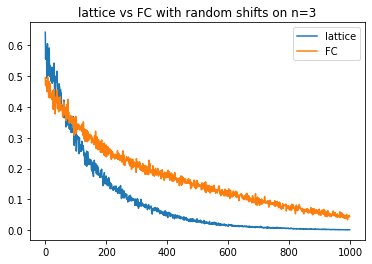

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


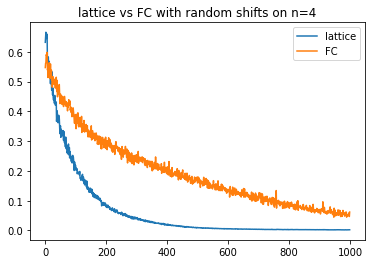

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


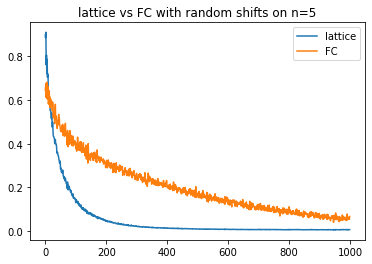

100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


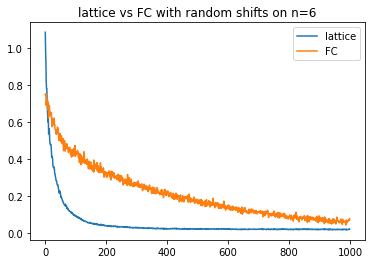

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


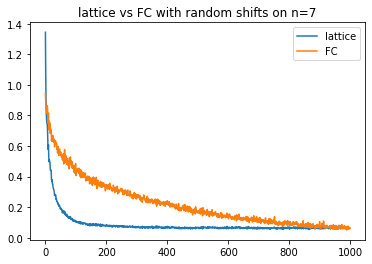

In [ ]:
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_nodes in range(3, 8):

  G = nx.OrderedDiGraph()
  permutations, edges = subset_lattice(n_nodes)
  G.add_nodes_from(range(np.power(2, n_nodes)))
  G.add_edges_from(edges)
  L = MeetSemiLattice(G)
  S = compute_shift_matrix(G)
  l_hist, t_hist = [], []

  for _ in tqdm(range(10)):

    lh, th  = [], []

    l_net = LatticeSumNet(L, out_channels=np.power(2, n_nodes), device=device)
    l_optim = optimizer.Adam(l_net.parameters())
    l_net.to(device)

    t_net = TestSumNet(L)
    t_optim = optimizer.Adam(t_net.parameters())
    t_net.to(device)

    for epoch in range(epochs):
      P = np.zeros((batch_size, np.power(2, n_nodes)))
      x = np.random.rand(n_nodes, batch_size)
      #x /= np.sum(x, axis=0)
      for i, p in enumerate(permutations): P[:, i] += np.sum(x[p], axis=0)
      x = np.flipud(np.vstack([np.zeros(batch_size), x, np.zeros((np.power(2, n_nodes) - n_nodes - 1, batch_size))]))

      r_shifts = np.random.randint(0, high=x.shape[0], size=batch_size) #np.zeros(batch_size, dtype=np.int) #
      x, y_true = shift_batch(S, x.T, r_shifts), shift_batch(S, P, r_shifts)
      x, y_true = torch.Tensor(x.copy()).to(device), torch.Tensor(y_true).to(device)

      l_optim.zero_grad()
      l_pred = torch.sum(l_net(torch.unsqueeze(x, dim=1)), dim=2)
      l_loss = nn.L1Loss()(l_pred, y_true)#torch.mean(torch.sum(torch.abs(y_true - l_pred), dim=1)) #criterion(y_pred, y_true)
      l_loss.backward()
      l_optim.step()
      lh.append(l_loss)

      t_optim.zero_grad()
      t_pred = t_net(x)
      t_loss = nn.L1Loss()(t_pred, y_true)#torch.mean(torch.sum(torch.abs(y_true - t_pred), dim=1)) #criterion(y_pred, y_true)
      t_loss.backward()
      t_optim.step()
      th.append(t_loss)

    l_hist.append(lh)
    t_hist.append(th)
  
  plt.plot(range(epochs), np.median(np.vstack(l_hist), axis=0), label=f'lattice')
  plt.plot(range(epochs), np.median(np.vstack(t_hist), axis=0), label=f'FC')
  plt.title(f'lattice vs FC with random shifts on n={n_nodes}')
  plt.ylim(bottom=0)
  plt.legend()
  plt.show()


100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


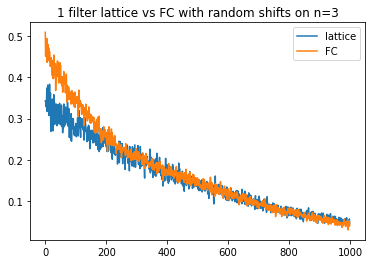

100%|██████████| 10/10 [00:27<00:00,  2.72s/it]


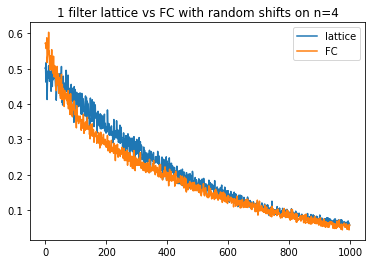

100%|██████████| 10/10 [00:28<00:00,  2.90s/it]


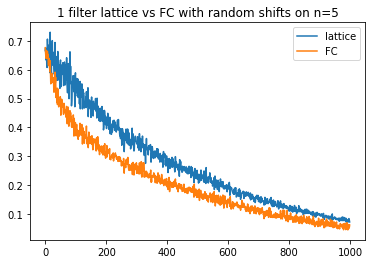

100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


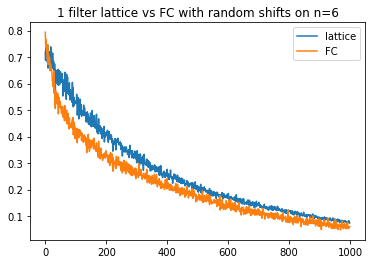

100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


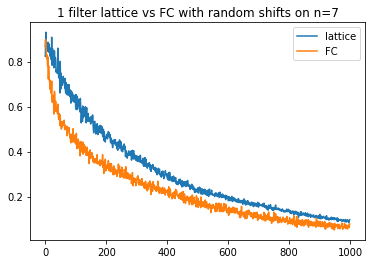

In [ ]:
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_nodes in range(3, 8):

  G = nx.OrderedDiGraph()
  permutations, edges = subset_lattice(n_nodes)
  G.add_nodes_from(range(np.power(2, n_nodes)))
  G.add_edges_from(edges)
  L = MeetSemiLattice(G)
  S = compute_shift_matrix(G)
  l_hist, t_hist = [], []

  for _ in tqdm(range(10)):

    lh, th  = [], []

    l_net = LatticeSumNet(L, device=device)
    l_optim = optimizer.Adam(l_net.parameters())
    l_net.to(device)

    t_net = TestSumNet(L)
    t_optim = optimizer.Adam(t_net.parameters())
    t_net.to(device)

    for epoch in range(epochs):
      P = np.zeros((batch_size, np.power(2, n_nodes)))
      x = np.random.rand(n_nodes, batch_size)
      #x /= np.sum(x, axis=0)
      for i, p in enumerate(permutations): P[:, i] += np.sum(x[p], axis=0)
      x = np.flipud(np.vstack([np.zeros(batch_size), x, np.zeros((np.power(2, n_nodes) - n_nodes - 1, batch_size))]))

      r_shifts = np.random.randint(0, high=x.shape[0], size=batch_size) #np.zeros(batch_size, dtype=np.int) #
      x, y_true = shift_batch(S, x.T, r_shifts), shift_batch(S, P, r_shifts)
      x, y_true = torch.Tensor(x.copy()).to(device), torch.Tensor(y_true).to(device)

      l_optim.zero_grad()
      l_pred = torch.squeeze(l_net(torch.unsqueeze(x, dim=1)))
      l_loss = nn.L1Loss()(l_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - l_pred), dim=1)) #criterion(y_pred, y_true)
      l_loss.backward()
      l_optim.step()
      lh.append(l_loss)

      t_optim.zero_grad()
      t_pred = t_net(x)
      t_loss = nn.L1Loss()(t_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - t_pred), dim=1)) #criterion(y_pred, y_true)
      t_loss.backward()
      t_optim.step()
      th.append(t_loss)

    l_hist.append(lh)
    t_hist.append(th)
  
  plt.plot(range(epochs), np.median(np.vstack(l_hist), axis=0), label=f'lattice')
  plt.plot(range(epochs), np.median(np.vstack(t_hist), axis=0), label=f'FC')
  plt.title(f'1 filter lattice vs FC with random shifts on n={n_nodes}')
  plt.ylim(bottom=0)
  plt.legend()
  plt.show()


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


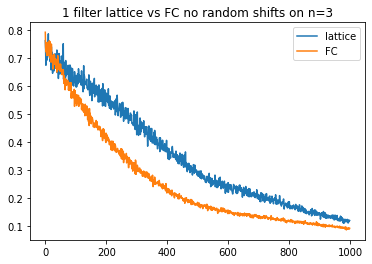

100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


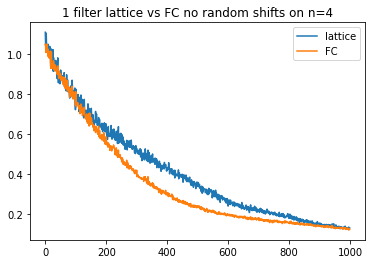

100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


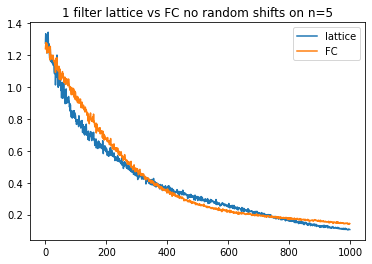

100%|██████████| 10/10 [00:32<00:00,  3.25s/it]


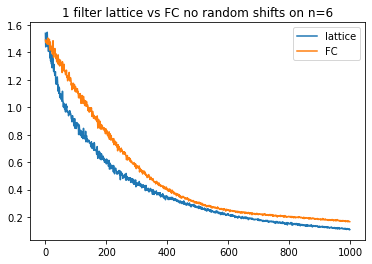

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


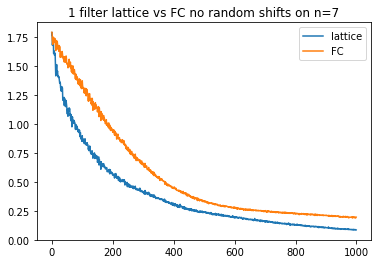

In [ ]:
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_nodes in range(3, 8):

  G = nx.OrderedDiGraph()
  permutations, edges = subset_lattice(n_nodes)
  G.add_nodes_from(range(np.power(2, n_nodes)))
  G.add_edges_from(edges)
  L = MeetSemiLattice(G)
  S = compute_shift_matrix(G)
  l_hist, t_hist = [], []

  for _ in tqdm(range(10)):

    lh, th  = [], []

    l_net = LatticeSumNet(L, device=device)
    l_optim = optimizer.Adam(l_net.parameters())
    l_net.to(device)

    t_net = TestSumNet(L)
    t_optim = optimizer.Adam(t_net.parameters())
    t_net.to(device)

    for epoch in range(epochs):
      P = np.zeros((batch_size, np.power(2, n_nodes)))
      x = np.random.rand(n_nodes, batch_size)
      #x /= np.sum(x, axis=0)
      for i, p in enumerate(permutations): P[:, i] += np.sum(x[p], axis=0)
      x = np.flipud(np.vstack([np.zeros(batch_size), x, np.zeros((np.power(2, n_nodes) - n_nodes - 1, batch_size))]))

      r_shifts = np.zeros(batch_size, dtype=np.int) #np.random.randint(0, high=x.shape[0], size=batch_size)  #
      x, y_true = shift_batch(S, x.T, r_shifts), shift_batch(S, P, r_shifts)
      x, y_true = torch.Tensor(x.copy()).to(device), torch.Tensor(y_true).to(device)

      l_optim.zero_grad()
      l_pred = torch.squeeze(l_net(torch.unsqueeze(x, dim=1)))
      l_loss = nn.L1Loss()(l_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - l_pred), dim=1)) #criterion(y_pred, y_true)
      l_loss.backward()
      l_optim.step()
      lh.append(l_loss)

      t_optim.zero_grad()
      t_pred = t_net(x)
      t_loss = nn.L1Loss()(t_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - t_pred), dim=1)) #criterion(y_pred, y_true)
      t_loss.backward()
      t_optim.step()
      th.append(t_loss)

    l_hist.append(lh)
    t_hist.append(th)
  
  plt.plot(range(epochs), np.median(np.vstack(l_hist), axis=0), label=f'lattice')
  plt.plot(range(epochs), np.median(np.vstack(t_hist), axis=0), label=f'FC')
  plt.title(f'1 filter lattice vs FC no random shifts on n={n_nodes}')
  plt.ylim(bottom=0)
  plt.legend()
  plt.show()


100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


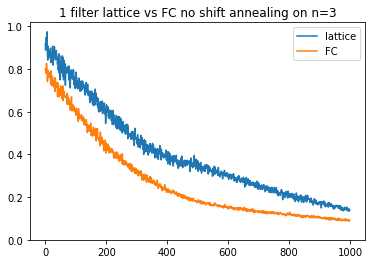

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


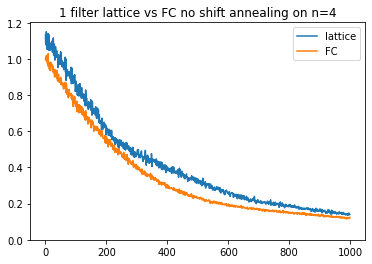

100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


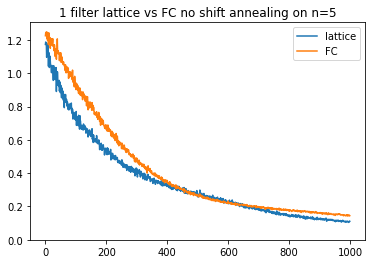

100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


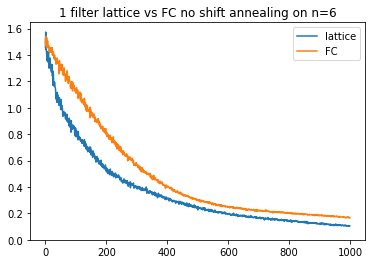

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]


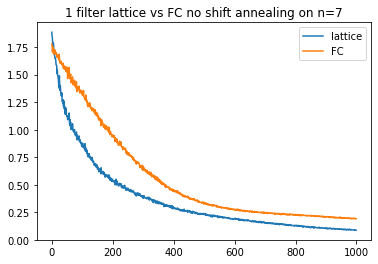

In [ ]:
epochs = 1000
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for n_nodes in range(3, 8):

  G = nx.OrderedDiGraph()
  permutations, edges = subset_lattice(n_nodes)
  G.add_nodes_from(range(np.power(2, n_nodes)))
  G.add_edges_from(edges)
  L = MeetSemiLattice(G)
  S = compute_shift_matrix(G)
  l_hist, t_hist = [], []

  for _ in tqdm(range(10)):

    T, lh, th  = 1, [], []

    l_net = LatticeSumNet(L, device=device)
    l_optim = optimizer.Adam(l_net.parameters())
    l_net.to(device)

    t_net = TestSumNet(L)
    t_optim = optimizer.Adam(t_net.parameters())
    t_net.to(device)

    for epoch in range(epochs):
      P = np.zeros((batch_size, np.power(2, n_nodes)))
      x = np.random.rand(n_nodes, batch_size)
      #x /= np.sum(x, axis=0)
      for i, p in enumerate(permutations): P[:, i] += np.sum(x[p], axis=0)
      x = np.flipud(np.vstack([np.zeros(batch_size), x, np.zeros((np.power(2, n_nodes) - n_nodes - 1, batch_size))]))

      r_shifts = np.zeros(batch_size, dtype=np.int) #np.random.randint(0, high=max(1, int(x.shape[0] * T)), size=batch_size) #
      x, y_true = shift_batch(S, x.T, r_shifts), shift_batch(S, P, r_shifts)
      x, y_true = torch.Tensor(x.copy()).to(device), torch.Tensor(y_true).to(device)

      l_optim.zero_grad()
      l_pred = torch.squeeze(l_net(torch.unsqueeze(x, dim=1)))
      l_loss = nn.L1Loss()(l_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - l_pred), dim=1)) #criterion(y_pred, y_true)
      l_loss.backward()
      l_optim.step()
      lh.append(l_loss)

      t_optim.zero_grad()
      t_pred = t_net(x)
      t_loss = nn.L1Loss()(t_pred, y_true) #torch.mean(torch.sum(torch.abs(y_true - t_pred), dim=1)) #criterion(y_pred, y_true)
      t_loss.backward()
      t_optim.step()
      th.append(t_loss)

      T *= 0.995

    l_hist.append(lh)
    t_hist.append(th)
  
  plt.plot(range(epochs), np.median(np.vstack(l_hist), axis=0), label=f'lattice')
  plt.plot(range(epochs), np.median(np.vstack(t_hist), axis=0), label=f'FC')
  plt.title(f'1 filter lattice vs FC no shift annealing on n={n_nodes}')
  plt.ylim(bottom=0)
  plt.legend()
  plt.show()


In [ ]:
print(nn.L1Loss()(l_pred, y_true))
print(nn.L1Loss()(t_pred, y_true))

tensor(0.0771, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.1288, device='cuda:0', grad_fn=<L1LossBackward>)


In [ ]:
print(nn.L1Loss()(l_pred, y_true))
print(nn.L1Loss()(t_pred, y_true))

tensor(0.0695, device='cuda:0', grad_fn=<L1LossBackward>)
tensor(0.0968, device='cuda:0', grad_fn=<L1LossBackward>)


In [ ]:
y_true

tensor([[3.1112, 3.0376, 2.5445,  ..., 0.5667, 0.0736, 0.0000],
        [3.5258, 3.0785, 2.9014,  ..., 0.6243, 0.4473, 0.0000],
        [4.0813, 3.2749, 3.2214,  ..., 0.8598, 0.8063, 0.0000],
        ...,
        [3.2570, 2.3869, 3.2011,  ..., 0.0559, 0.8701, 0.0000],
        [2.9600, 2.8218, 2.0688,  ..., 0.8912, 0.1382, 0.0000],
        [3.9974, 3.6838, 3.4055,  ..., 0.5919, 0.3137, 0.0000]],
       device='cuda:0')

# Mallows Voter Task

In [ ]:
!git clone https://github.com/PrefLib/PrefLib-Tools.git
!cd /content/PrefLib-Tools/preflibtools && pip3 install -e .
!unzip /content/permutation_lattice_cover_graphs.zip

fatal: destination path 'PrefLib-Tools' already exists and is not an empty directory.
Obtaining file:///content/PrefLib-Tools/preflibtools
  Found existing installation: preflibtools 1.5.1
    Can't uninstall 'preflibtools'. No files were found to uninstall.
  Running setup.py develop for preflibtools
Archive:  /content/permutation_lattice_cover_graphs.zip
  inflating: S6_covers_graph.mat     
  inflating: S5_covers_graph.mat     
  inflating: S4_covers_graph.mat     
  inflating: S3_covers_graph.mat     
  inflating: S7_covers_graph.mat     


In [ ]:
import preflibtools.generate_profiles as profiles
import preflibtools.io as prefio
from scipy.io import loadmat


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


def vote2tuple(vote):
  v = np.zeros(len(vote), dtype=np.int)
  for c, p in vote.items():
    v[p - 1] = c

  return tuple(v)


def gen_rand_mallows(nvoters, ncand, nref):
  mix = []
  phis = []
  refs = []
  candmap = profiles.gen_cand_map(ncand)
  for i in range(nref):
    refm, refc = profiles.gen_impartial_culture_strict(1, candmap);
    refs.append(prefio.rankmap_to_order(refm[0]))
    phis.append(round(np.random.random(), 5))
    mix.append(np.random.randint(1,100))

  smix = sum(mix)
  mix = [float(i) / float(smix) for i in mix]
  return mix, phis, refs, profiles.gen_mallows(nvoters, candmap, mix, phis, refs)


def gen_votes(n_votes, n_cand, P, n_refs=1):
  x, y = np.zeros(np.math.factorial(n_cand)), np.zeros(np.math.factorial(n_cand))
  mix, _, refs, votes = gen_rand_mallows(n_votes, n_cand, n_refs)
  
  for vote, count in map(lambda v: (vote2tuple(v[0]), v[1]), zip(votes[0], votes[1])):
    x[P[vote]] = count

  for ref, mx in map(lambda r: (P[tuple(r[0])], r[1]), zip(refs, mix)):
    y[ref] += mx

  return x, y


def gen_batch(n_votes, n_cand, P, batch=32, epochs=1, n_refs=1):
  X, Y = [], []
  for _ in range(epochs):
    x, y = zip(*[gen_votes(n_votes, n_cand, P, n_refs=n_refs) for _ in range(batch)])
    yield np.vstack(x) / n_votes, np.vstack(y)


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


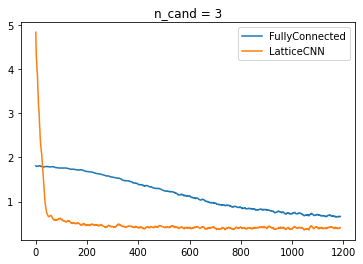

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


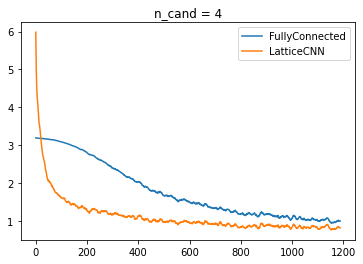

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


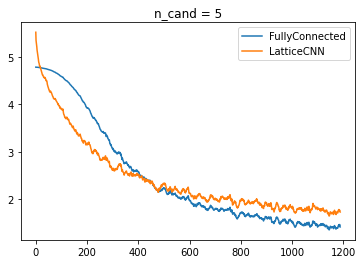

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


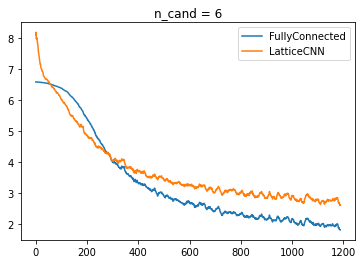

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


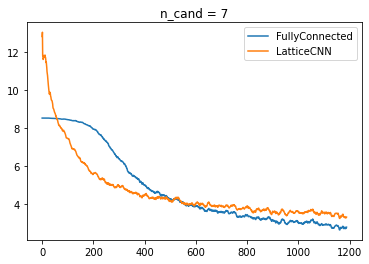

In [ ]:
R = 12
epochs = 1200
n_votes = 100
batch_size = 128
criterion = nn.CrossEntropyLoss() #optimizer.SGD(net.parameters(), lr=0.001, momentum=0.9)

for n_cand in range(3, 8): #range(1):

  S = loadmat(f'/content/S{n_cand}_covers_graph.mat')
  P = map(lambda p: tuple(map(lambda s: int(s), p[1:-1].split(','))), S['permutations'])
  P = {t: i for i, t in enumerate(P)}
  
  fc_l, latt_l = [], []
  G = nx.OrderedDiGraph()
  n_nodes = len(S['permutations'])
  G.add_nodes_from(range(n_nodes))
  G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])
  
  latt_net =  LatticeNet(MeetSemiLattice(G), n_layers=0, n_filters=256, device=device).to(device)
  latt_optim = optimizer.Adam(latt_net.parameters())
  fc_net = TestNet(n_nodes, n_nodes).to(device)
  fc_optim = optimizer.Adam(fc_net.parameters())

  data_it = enumerate(gen_batch(n_votes, n_cand, P, batch=batch_size, epochs=epochs))

  for epoch, (X, y) in data_it:
    
    y_true = torch.LongTensor(np.argmax(y, axis=1)).to(device)
    X = torch.unsqueeze(torch.Tensor(X).to(device), dim=1)
    
    latt_optim.zero_grad()
    latt_pred = latt_net(X)
    latt_loss = criterion(torch.squeeze(latt_pred), y_true)
    latt_loss.backward()
    latt_optim.step()
    latt_l.append(latt_loss.item())

    fc_optim.zero_grad()
    fc_pred = fc_net(torch.squeeze(X))
    fc_loss = criterion(fc_pred, y_true)
    fc_loss.backward()
    fc_optim.step()
    fc_l.append(fc_loss.item())

    if not epoch % 100: print(f'{epoch}/{epochs}')

  plt.plot(list(range(epochs - R + 1)), running_mean(fc_l, R), label='FullyConnected')
  plt.plot(list(range(epochs - R + 1)), running_mean(latt_l, R), label='LatticeCNN')
  plt.title(f'n_cand = {n_cand}')
  plt.legend()
  plt.show()


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


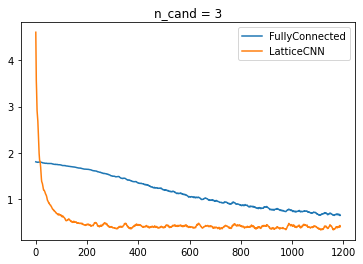

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


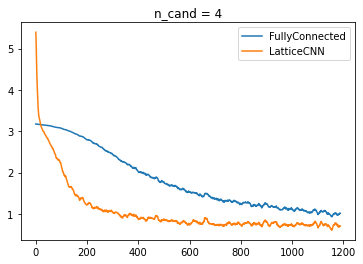

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


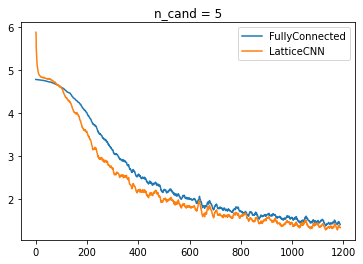

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


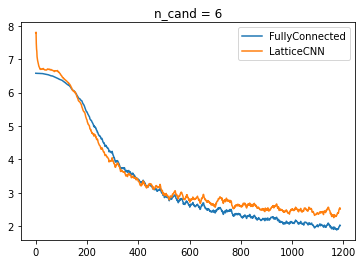

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


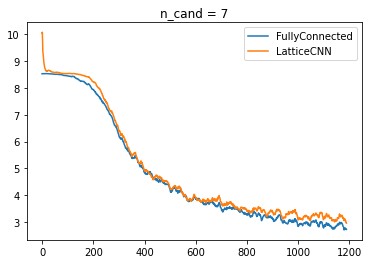

In [ ]:

R = 12
epochs = 1200
n_votes = 100
batch_size = 128
criterion = nn.CrossEntropyLoss() #optimizer.SGD(net.parameters(), lr=0.001, momentum=0.9)

for n_cand in range(3, 8): #range(1):

  S = loadmat(f'/content/S{n_cand}_covers_graph.mat')
  P = map(lambda p: tuple(map(lambda s: int(s), p[1:-1].split(','))), S['permutations'])
  P = {t: i for i, t in enumerate(P)}
  
  fc_l, latt_l = [], []
  G = nx.OrderedDiGraph()
  n_nodes = len(S['permutations'])
  G.add_nodes_from(range(n_nodes))
  G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])
  
  latt_net =  LatticeNet(MeetSemiLattice(G), n_layers=1, n_filters=64, device=device).to(device)
  latt_optim = optimizer.Adam(latt_net.parameters())
  fc_net = TestNet(n_nodes, n_nodes).to(device)
  fc_optim = optimizer.Adam(fc_net.parameters())

  data_it = enumerate(gen_batch(n_votes, n_cand, P, batch=batch_size, epochs=epochs))

  for epoch, (X, y) in data_it:
    
    y_true = torch.LongTensor(np.argmax(y, axis=1)).to(device)
    X = torch.unsqueeze(torch.Tensor(X).to(device), dim=1)
    
    latt_optim.zero_grad()
    latt_pred = latt_net(X)
    latt_loss = criterion(torch.squeeze(latt_pred), y_true)
    latt_loss.backward()
    latt_optim.step()
    latt_l.append(latt_loss.item())

    fc_optim.zero_grad()
    fc_pred = fc_net(torch.squeeze(X))
    fc_loss = criterion(fc_pred, y_true)
    fc_loss.backward()
    fc_optim.step()
    fc_l.append(fc_loss.item())

    if not epoch % 100: print(f'{epoch}/{epochs}')

  plt.plot(list(range(epochs - R + 1)), running_mean(fc_l, R), label='FullyConnected')
  plt.plot(list(range(epochs - R + 1)), running_mean(latt_l, R), label='LatticeCNN')
  plt.title(f'n_cand = {n_cand}')
  plt.legend()
  plt.show()


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


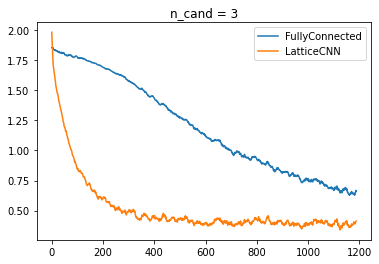

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


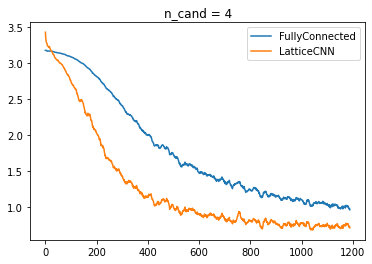

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


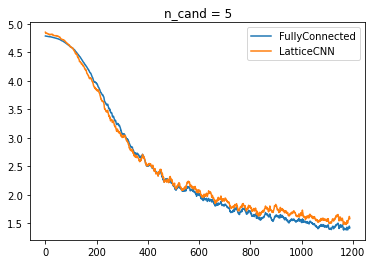

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


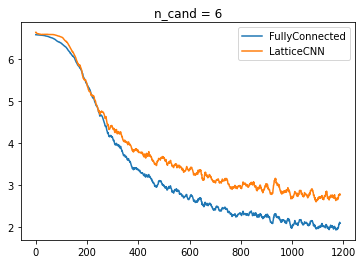

0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


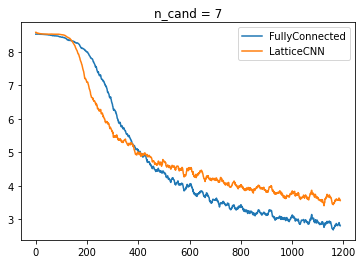

In [ ]:
R = 12
epochs = 1200
n_votes = 100
batch_size = 128
criterion = nn.CrossEntropyLoss() #optimizer.SGD(net.parameters(), lr=0.001, momentum=0.9)

for n_cand in range(3, 8): #range(1):

  S = loadmat(f'/content/S{n_cand}_covers_graph.mat')
  P = map(lambda p: tuple(map(lambda s: int(s), p[1:-1].split(','))), S['permutations'])
  P = {t: i for i, t in enumerate(P)}
  
  fc_l, latt_l = [], []
  G = nx.OrderedDiGraph()
  n_nodes = len(S['permutations'])
  G.add_nodes_from(range(n_nodes))
  G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])
  
  latt_net =  LatticeNet(MeetSemiLattice(G), n_layers=1, n_filters=16, device=device).to(device)
  latt_optim = optimizer.Adam(latt_net.parameters())
  fc_net = TestNet(n_nodes, n_nodes).to(device)
  fc_optim = optimizer.Adam(fc_net.parameters())

  data_it = enumerate(gen_batch(n_votes, n_cand, P, batch=batch_size, epochs=epochs))

  for epoch, (X, y) in data_it:
    
    y_true = torch.LongTensor(np.argmax(y, axis=1)).to(device)
    X = torch.unsqueeze(torch.Tensor(X).to(device), dim=1)
    
    latt_optim.zero_grad()
    latt_pred = latt_net(X)
    latt_loss = criterion(torch.squeeze(latt_pred), y_true)
    latt_loss.backward()
    latt_optim.step()
    latt_l.append(latt_loss.item())

    fc_optim.zero_grad()
    fc_pred = fc_net(torch.squeeze(X))
    fc_loss = criterion(fc_pred, y_true)
    fc_loss.backward()
    fc_optim.step()
    fc_l.append(fc_loss.item())

    if not epoch % 100: print(f'{epoch}/{epochs}')

  plt.plot(list(range(epochs - R + 1)), running_mean(fc_l, R), label='FullyConnected')
  plt.plot(list(range(epochs - R + 1)), running_mean(latt_l, R), label='LatticeCNN')
  plt.t itle(f'n_cand = {n_cand}')
  plt.legend()
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


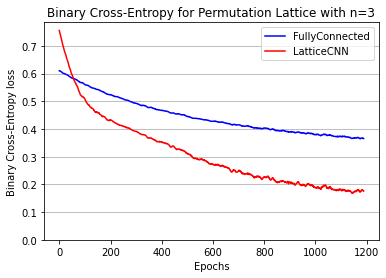

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


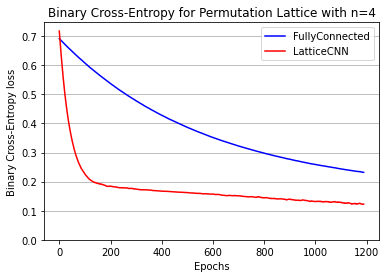

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


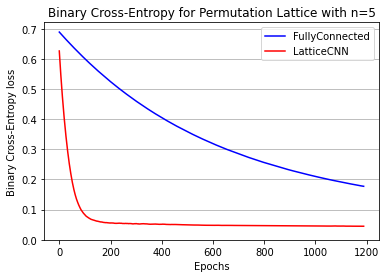

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


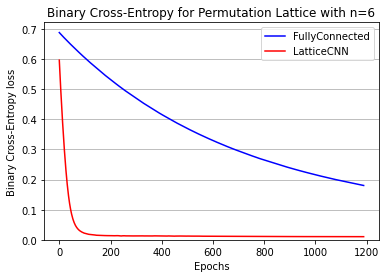

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/1200
100/1200
200/1200
300/1200
400/1200
500/1200
600/1200
700/1200
800/1200
900/1200
1000/1200
1100/1200


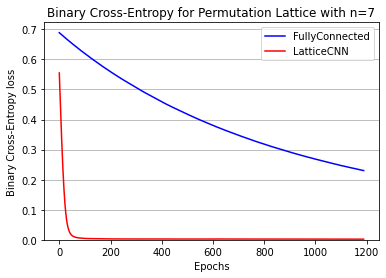

In [ ]:

R = 12
epochs = 1200
n_votes = 100
batch_size = 128
criterion = nn.BCELoss() #optimizer.SGD(net.parameters(), lr=0.001, momentum=0.9)

for n_cand in range(3, 8): #range(1):

  S = loadmat(f'/content/S{n_cand}_covers_graph.mat')
  P = map(lambda p: tuple(map(lambda s: int(s), p[1:-1].split(','))), S['permutations'])
  P = {t: i for i, t in enumerate(P)}
  
  fc_l, latt_l = [], []
  G = nx.OrderedDiGraph()
  n_nodes = len(S['permutations'])
  G.add_nodes_from(range(n_nodes))
  G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])

  Perm_Lattice = MeetSemiLattice(G)
  
  latt_net =  LatticeNet(Perm_Lattice, n_layers=0, n_filters=8, device=device).to(device)
  latt_optim = optimizer.Adam(latt_net.parameters())

  fc_net = TestSumNet(Perm_Lattice).to(device)
  fc_optim = optimizer.Adam(fc_net.parameters())

  data_it = enumerate(gen_batch(n_votes, n_cand, P, batch=batch_size, epochs=epochs))

  for epoch, (X, y) in data_it:
    
    y_true = torch.Tensor(y).to(device)
    X = torch.unsqueeze(torch.Tensor(X).to(device), dim=1)
    
    latt_optim.zero_grad()
    latt_pred = latt_net(X)
    latt_loss = criterion(torch.sigmoid(torch.squeeze(latt_pred)), y_true)
    latt_loss.backward()
    latt_optim.step()
    latt_l.append(latt_loss.item())

    fc_optim.zero_grad()
    fc_pred = fc_net(torch.squeeze(X))
    fc_loss = criterion(torch.sigmoid(fc_pred), y_true)
    fc_loss.backward()
    fc_optim.step()
    fc_l.append(fc_loss.item())

    if not epoch % 100: print(f'{epoch}/{epochs}')

  plt.plot(list(range(epochs - R + 1)), running_mean(fc_l, R), 'b', label='FullyConnected')
  plt.plot(list(range(epochs - R + 1)), running_mean(latt_l, R), 'r', label='LatticeCNN')
  plt.title(f'Binary Cross-Entropy for Permutation Lattice with n={n_cand}')
  plt.xlabel('Epochs')
  ylabel = plt.ylabel('Binary Cross-Entropy loss')
  plt.gca().yaxis.grid(True)
  plt.ylim(bottom=0)
  plt.legend()
  plt.legend()
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/500
100/500
200/500
300/500
400/500


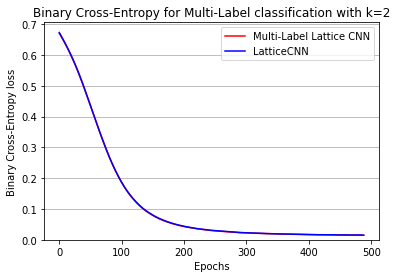

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/500
100/500
200/500
300/500
400/500


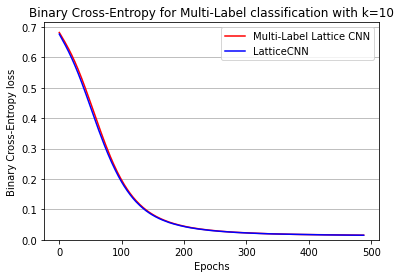

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/500
100/500
200/500
300/500
400/500


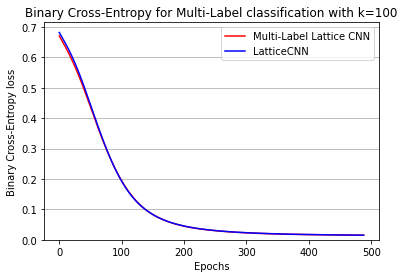

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.


0/500
100/500
200/500
300/500
400/500


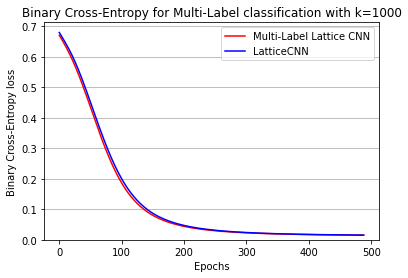

In [ ]:

R = 12
epochs = 500
n_votes = 100
batch_size = 128
criterion = nn.BCELoss() #optimizer.SGD(net.parameters(), lr=0.001, momentum=0.9)

for subset in range(0, 4): #range(1):

  S = loadmat(f'/content/S6_covers_graph.mat')
  P = map(lambda p: tuple(map(lambda s: int(s), p[1:-1].split(','))), S['permutations'])
  P = {t: i for i, t in enumerate(P)}
  
  ml_l, latt_l = [], []
  G = nx.OrderedDiGraph()
  n_nodes = len(S['permutations'])
  G.add_nodes_from(range(n_nodes))
  G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])

  Perm_Lattice = MeetSemiLattice(G)
  
  latt_net =  LatticeNet(Perm_Lattice, n_layers=0, n_filters=1, device=device).to(device)
  latt_optim = optimizer.Adam(latt_net.parameters())

  multi_label = LatticeNet(Perm_Lattice, n_layers=0, n_filters=1, device=device).to(device)
  ml_optim = optimizer.Adam(multi_label.parameters())

  data_it = enumerate(gen_batch(n_votes, 6, P, batch=batch_size, epochs=epochs, n_refs=[2, 10, 100, 300][subset]))

  for epoch, (X, y) in data_it:
    
    y_true = torch.Tensor(y).to(device)
    X = torch.unsqueeze(torch.Tensor(X).to(device), dim=1)
    
    latt_optim.zero_grad()
    latt_pred = latt_net(X)
    latt_loss = criterion(torch.sigmoid(torch.squeeze(latt_pred)), y_true)
    latt_loss.backward()
    latt_optim.step()
    latt_l.append(latt_loss.item())

    ml_optim.zero_grad()
    ml_pred = multi_label(X)
    ml_loss = criterion(torch.sigmoid(torch.squeeze(ml_pred)), y_true)
    ml_loss.backward()
    ml_optim.step()
    ml_l.append(ml_loss.item())

    if not epoch % 100: print(f'{epoch}/{epochs}')

  plt.plot(list(range(epochs - R + 1)), running_mean(ml_l, R), 'r', label='Multi-Label Lattice CNN')
  plt.plot(list(range(epochs - R + 1)), running_mean(latt_l, R), 'b', label='LatticeCNN')
  plt.title(f'Binary Cross-Entropy for Multi-Label classification with k={[2, 10, 100, 1000][subset]}')
  plt.xlabel('Epochs')
  ylabel = plt.ylabel('Binary Cross-Entropy loss')
  plt.gca().yaxis.grid(True)
  plt.ylim(bottom=0)
  plt.legend()
  plt.legend()
  plt.show()


In [ ]:
sum(p.numel() for p in fc_net.parameters() if p.requires_grad)

50813280

In [ ]:
#net = LatticeNet(L, n_layers=0, n_filters=3, device=device)
sum(p.numel() for p in t_net.parameters() if p.requires_grad)

16512

In [ ]:
5977440/50813280

0.1176353898036104

In [ ]:
S = loadmat(f'/content/S6_covers_graph.mat')
G = nx.OrderedDiGraph()
n_nodes = len(S['permutations'])
G.add_nodes_from(range(n_nodes))
G.add_edges_from([(j, i) for j in range(n_nodes) for i in range(n_nodes) if S['covers_graph'][i, j]])
L7 = MeetSemiLattice(G)


In [ ]:
net =  LatticeNet(L7, n_layers=1, n_filters=16, device=device)
sum(p.numel() for p in net.parameters() if p.requires_grad)

853920

In [ ]:
y_true

tensor([3, 5, 3, 5, 4, 0, 4, 1, 1, 1, 3, 0, 5, 2, 0, 3, 5, 3, 4, 0, 1, 5, 2, 0,
        1, 4, 5, 3, 1, 2, 5, 1, 4, 4, 0, 4, 5, 0, 2, 2, 1, 5, 0, 0, 0, 1, 1, 1,
        2, 3, 4, 5, 3, 3, 0, 5, 3, 0, 4, 1, 1, 1, 3, 3, 1, 3, 4, 2, 0, 5, 4, 1,
        2, 4, 2, 1, 3, 1, 1, 2, 5, 5, 1, 5, 2, 0, 0, 2, 4, 2, 4, 3, 0, 0, 3, 1,
        2, 5, 1, 2, 5, 3, 1, 0, 5, 4, 5, 3, 4, 2, 5, 2, 0, 2, 4, 3, 5, 4, 5, 5,
        4, 5, 3, 4, 5, 4, 4, 1], device='cuda:0')